In [342]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [343]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
import os
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

# Setup the notebook.

In [344]:
import h5py
import math
import random
testNames=[
        "reflecting_global",
        "absorbing_global",
        "absorbing_x",
        "absorbing_y",
        "absorbing_z",
        "periodic_global",
        "periodic_x",
        "periodic_y",
        "periodic_z",
        ]
test_names_bash_list=" ".join(testNames)

In [345]:
%%bash
rm -rf tmp && mkdir tmp

In [346]:
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [347]:
def buildUniformLattice(filename):
    fp = h5py.File(filename, "a")
    sites=fp["/Model/Diffusion/LatticeSites"]
    sites[:,:,:] = 0
    initialCounts=fp["/Model/Reaction/InitialSpeciesCounts"]
    particles=fp["/Model/Diffusion/Lattice"]
    placed = 0
    x=particles.shape[0]//2
    y=particles.shape[1]//2
    z=particles.shape[2]//2
    for p in range(16):
        particles[x,y,z,p] = p
        placed += 1
    print "Placed %d particles of type %d."%(placed,0)
    fp.close()

# Execute the simulations.

In [348]:
%%bash -s "$test_names_bash_list"
sbmlFilename="diffusion_model.sbml"
for testName in $1; do
    outputFilename=tmp/${testName}.lm
    rm -f ${outputFilename}*
    lm_sbml_import ${outputFilename} ${sbmlFilename} > ${outputFilename}.import.log
    if [[ ${testName} == reflecting_* ]]; then
        lm_setdm ${outputFilename} PlaceParticles=0 numberReactions=0 numberSpecies=16 numberSiteTypes=1 "latticeSize=[51,51,51]" latticeSpacing=1e-6 particlesPerSite=16 "DiffusionMatrix(:,:,:)=[1e-10]" "ReactionLocationMatrix=[]" > ${outputFilename}.setdm.log
        lm_setp ${outputFilename} maxTime=1e0 writeInterval=1e-1 latticeWriteInterval=1e-1 > /dev/null
        bc=REFLECTING
    elif [[ ${testName} == absorbing_* ]]; then
        lm_setdm ${outputFilename} PlaceParticles=0 numberReactions=0 numberSpecies=16 numberSiteTypes=1 "latticeSize=[51,51,51]" latticeSpacing=1e-6 particlesPerSite=16 "DiffusionMatrix(:,:,:)=[1e-10]" "ReactionLocationMatrix=[]" > ${outputFilename}.setdm.log
        lm_setp ${outputFilename} maxTime=2e0 writeInterval=1e-1 latticeWriteInterval=1e-1 > /dev/null
        bc=ABSORBING
    elif [[ ${testName} == periodic_* ]]; then
        lm_setdm ${outputFilename} PlaceParticles=0 numberReactions=0 numberSpecies=16 numberSiteTypes=1 "latticeSize=[21,21,21]" latticeSpacing=1e-6 particlesPerSite=16 "DiffusionMatrix(:,:,:)=[1e-10]" "ReactionLocationMatrix=[]" > ${outputFilename}.setdm.log
        lm_setp ${outputFilename} maxTime=2e0 writeInterval=1e-2 latticeWriteInterval=1e-2 > /dev/null
        bc=PERIODIC
    else
        echo "Invalid test name: ${testName}"
        continue
    fi
    if [[ ${testName} == *_global ]]; then
        lm_setp ${outputFilename} boundaryConditions=${bc} > /dev/null
    elif [[ ${testName} == *_x ]]; then
        lm_setp ${outputFilename} boundaryConditions=x:${bc},y:REFLECTING,z:REFLECTING > /dev/null
    elif [[ ${testName} == *_y ]]; then
        lm_setp ${outputFilename} boundaryConditions=x:REFLECTING,y:${bc},z:REFLECTING > /dev/null
    elif [[ ${testName} == *_z ]]; then
        lm_setp ${outputFilename} boundaryConditions=x:REFLECTING,y:REFLECTING,z:${bc} > /dev/null
    else
        echo "Invalid test name: ${testName}"
        continue
    fi
done;
echo "Finished."

Finished.


In [349]:
# Construct the lattices.
for testName in testNames:
    buildUniformLattice("tmp/%s.lm"%(testName))
print "Finished."

Placed 16 particles of type 0.
Placed 16 particles of type 0.
Placed 16 particles of type 0.
Placed 16 particles of type 0.
Placed 16 particles of type 0.
Placed 16 particles of type 0.
Placed 16 particles of type 0.
Placed 16 particles of type 0.
Placed 16 particles of type 0.
Finished.


In [350]:
%%bash -s "$test_names_bash_list"
for testName in $1; do
    outputFilename=tmp/${testName}.lm
    lmes -sp -r 1-10 -f ${outputFilename} > ${outputFilename}.simulate.log
done;
echo "Finished."

Finished.


# Spot check some simulations.

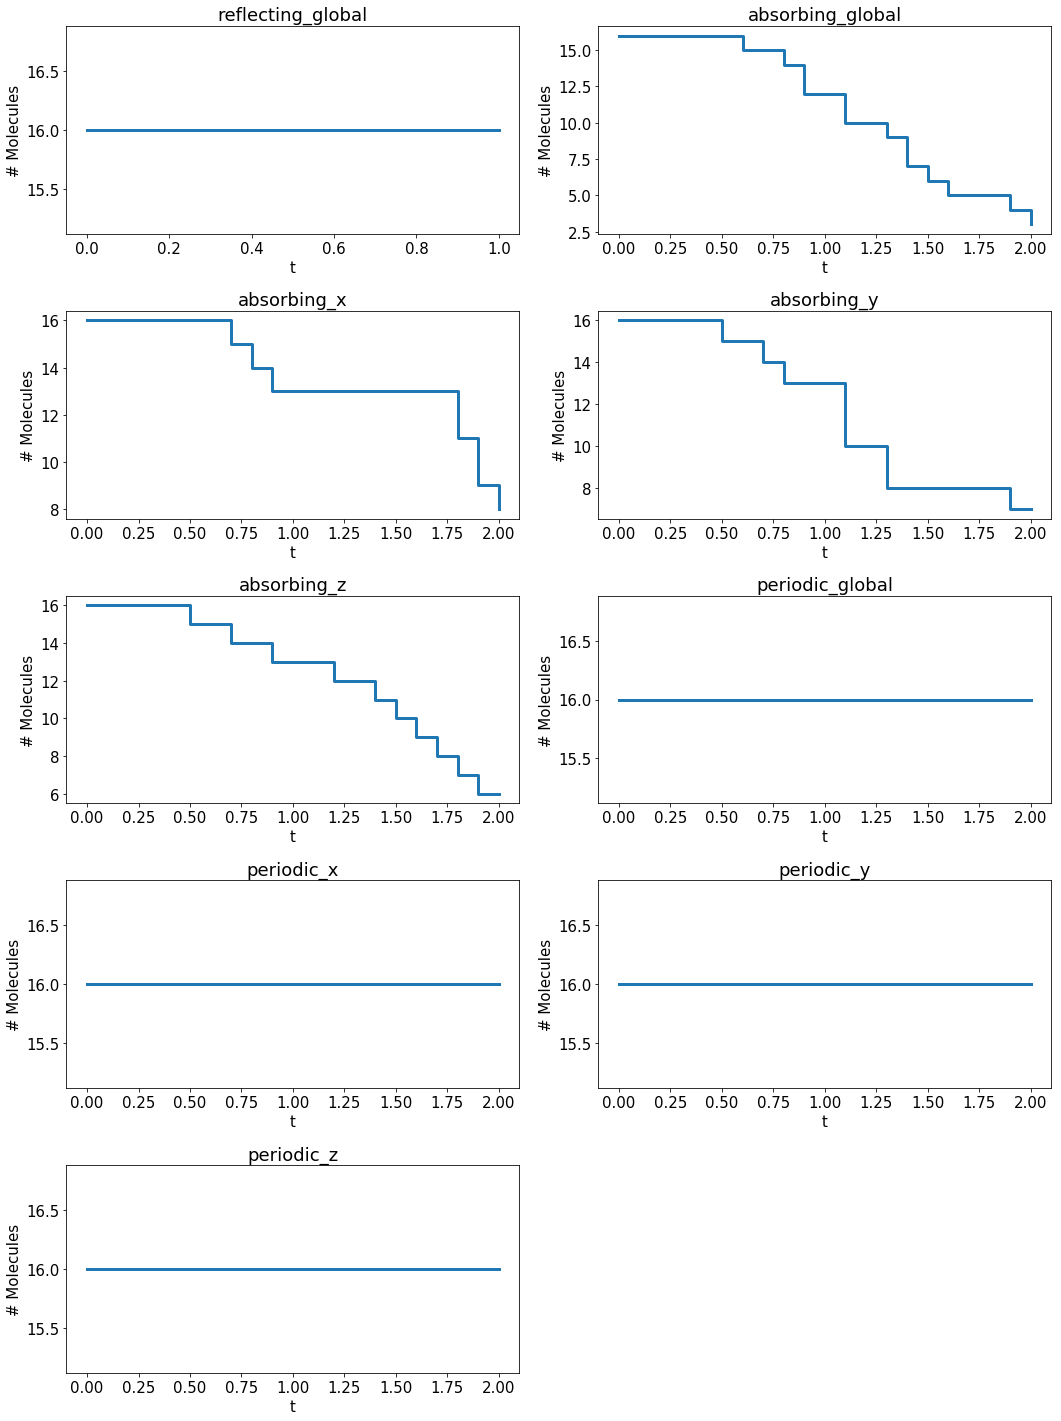

In [351]:
# Plot the time series for a single replicate.
for i,testName in enumerate(testNames):
    testOutputFilename="tmp/%s.lm"%(testName)
    fp = h5py.File(testOutputFilename, "r")
    cols=2
    rows=len(testNames)//cols
    if rows*cols < len(testNames): rows += 1
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,4*rows)})
    for replicate in (1,):
        counts=np.array(fp["/Simulations/%07d/SpeciesCounts"%replicate], dtype=double)
        times=np.array(fp["/Simulations/%07d/SpeciesCountTimes"%replicate], dtype=double)
        plt.subplot(rows,cols,i+1)
        step(times,np.sum(counts[:,:],1), **stepStyles)
        xlabel('t'); ylabel('# Molecules'); title("%s"%(testName))
    fp.close()
plt.tight_layout()
pass

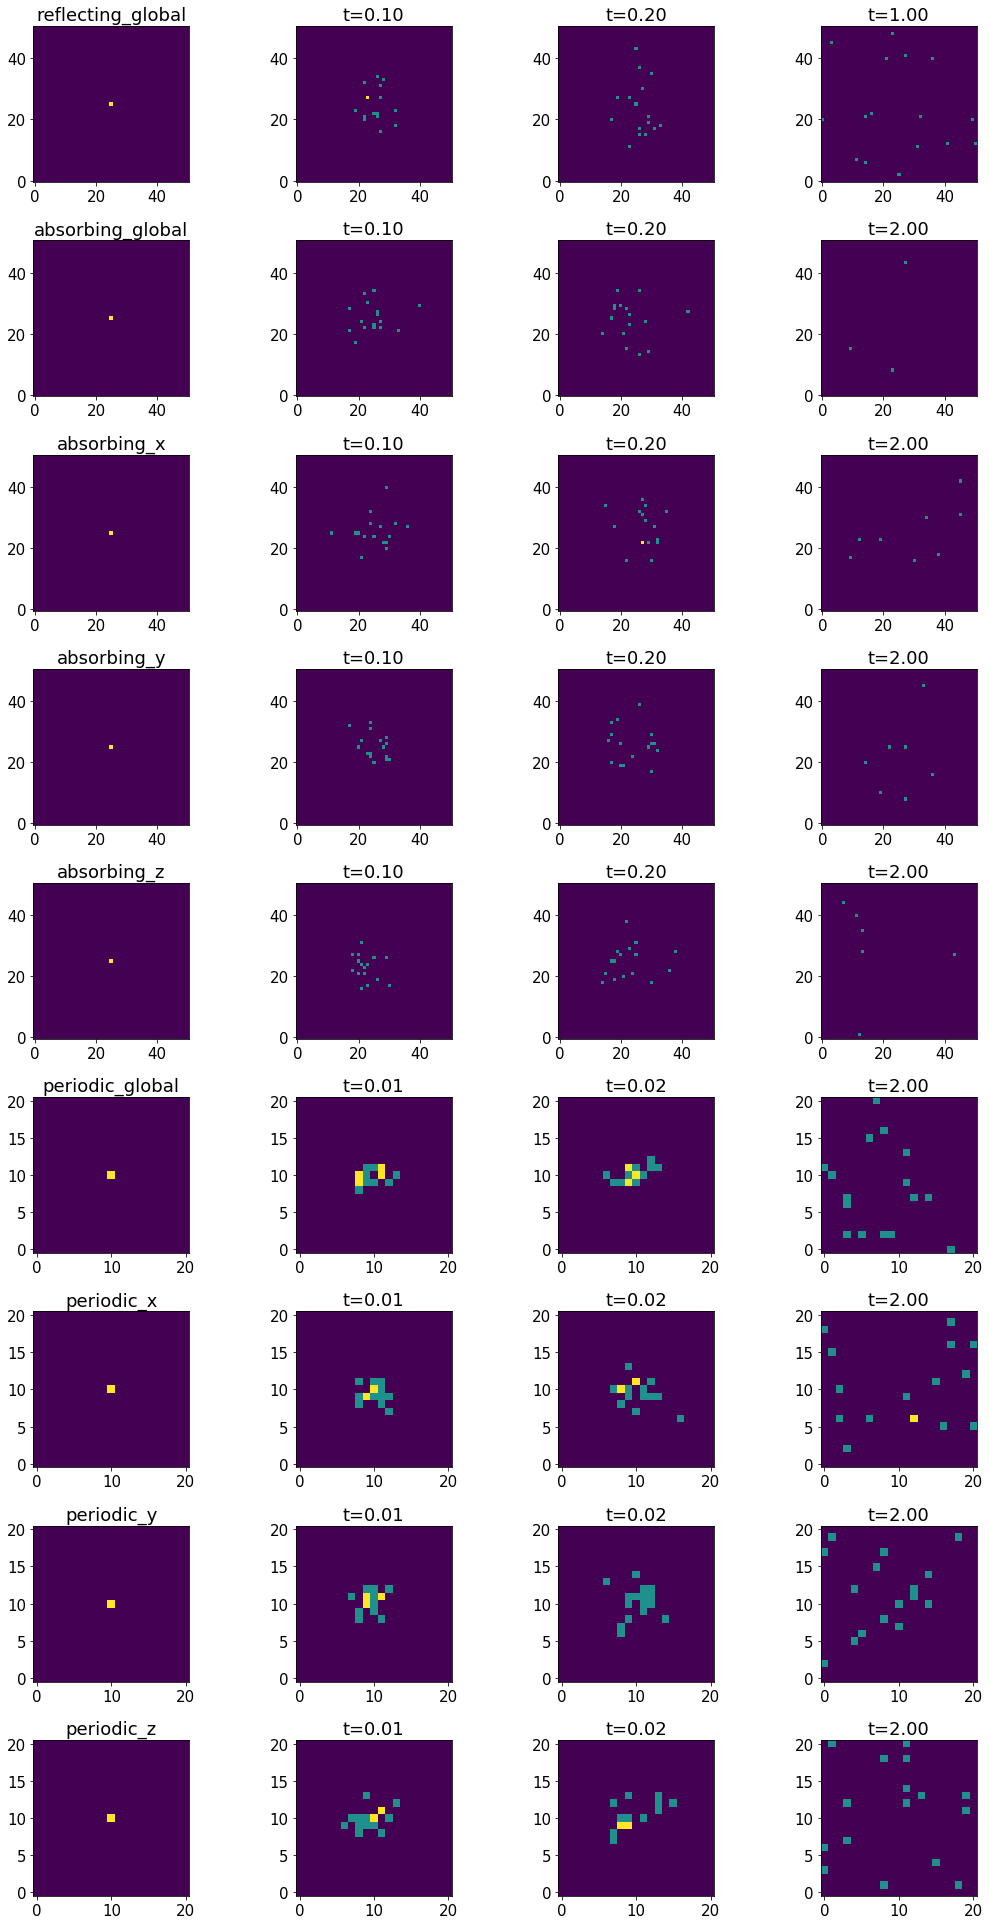

In [352]:
# Plot the time series for a single replicate.
rows=len(testNames)
cols=4
for i,testName in enumerate(testNames):
    testOutputFilename="tmp/%s.lm"%(testName)
    fp = h5py.File(testOutputFilename, "r")
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,3*rows)})
    replicate=1
    lattices=fp["/Simulations/%07d/Lattice"%replicate].keys()
    times=fp["/Simulations/%07d/LatticeTimes"%replicate]
    latticeIndices=(0,1,2,len(lattices)-1)
    for j in range(len(latticeIndices)):
        lfull = np.array(fp["/Simulations/%07d/Lattice/%s"%(replicate,lattices[latticeIndices[j]])], dtype=np.uint8)
        lc = np.sum(lfull!=255,3)
        plt.subplot(rows,cols,i*cols+j+1)
        plt.imshow(np.sum(lc[:,:,:],2), origin='lower', interpolation="none", vmin=0.0, vmax=2.0)
        if j == 0:
            title("%s"%testName)
        else:
            title("t=%0.2f"%times[latticeIndices[j]])
    fp.close()
plt.tight_layout()
pass

# Define some tests.

In [359]:
def test_reflecting_diffusion(testOutputFilename):
    
    # Compare the species and lattice output.
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    for replicate in replicates:
        times = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        latticeTimes = np.array(fp["/Simulations/%s/LatticeTimes"%replicate], dtype=double)
        if not np.array_equal(times.shape, latticeTimes.shape): raise Exception("time and lattice time not equal for replicate",replicate)
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        latticeNames = fp["/Simulations/%s/Lattice"%replicate].keys()
        if counts.shape[0] != len(latticeNames): raise Exception("number of counts and lattices not equal for replicate",replicate)
        ti=0
        for latticeName in latticeNames:
            lattice = np.array(fp["/Simulations/%s/Lattice/%s"%(replicate,latticeName)], dtype=np.uint8)
            for p in range(counts.shape[1]):
                latticeCount = np.sum(lattice==p)
                if counts[ti,p] != latticeCount: raise Exception("counts and lattice counts not equal for replicate and time",replicate,latticeName)
            ti+=1
        
        # Check that we aren't losing particles.
        for i in range(times.shape[0]):
            if np.sum(counts[i,]) != np.sum(counts[0,]): raise Exception("invalid number of particles at time %d and replicate %s"%(times[i],replicate))

    # Calculate the MSD vs time.
    msd=None
    valuesAdded=0
    for replicate in replicates:
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        latticeTimes = np.array(fp["/Simulations/%s/LatticeTimes"%replicate], dtype=double)
        latticeNames = fp["/Simulations/%s/Lattice"%replicate].keys()
        origin = np.zeros((counts.shape[1],3))
        if msd is None:
            msd = np.zeros((counts.shape[0],3))
        for ti,latticeName in enumerate(latticeNames):
            lattice = np.array(fp["/Simulations/%s/Lattice/%s"%(replicate,latticeName)], dtype=np.uint8)
            for p in range(counts.shape[1]):
                pos = np.where(lattice==p)
                pos = (pos[0][0],pos[1][0],pos[2][0])
                if ti == 0: origin[p,:] = pos
                msd[ti,:] += (pos-origin[p])**2
    msd /= len(replicates)*counts.shape[1]
    msd_theory = 2*1e-10*1e12*latticeTimes
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,5)})
    plt.subplot(2,3,1)
    plt.plot(latticeTimes, msd[:,0], 'bx')
    plt.plot(latticeTimes, msd_theory, 'r-')
    xlabel("t"); ylabel("MSD ($\mu$m)"); title("x")
    plt.subplot(2,3,2)
    plt.plot(latticeTimes, msd[:,1], 'bx')
    plt.plot(latticeTimes, msd_theory, 'r-')
    xlabel("t"); ylabel("MSD ($\mu$m)"); title("y")
    plt.subplot(2,3,3)
    plt.plot(latticeTimes, msd[:,2], 'bx')
    plt.plot(latticeTimes, msd_theory, 'r-')
    xlabel("t"); ylabel("MSD ($\mu$m)"); title("z")
    plt.subplot(2,3,4)
    plt.plot(latticeTimes, abs(msd[:,0]-msd_theory)/msd_theory, 'b')
    xlabel("t"); ylabel("Error"); yscale('log');
    plt.subplot(2,3,5)
    plt.plot(latticeTimes, abs(msd[:,1]-msd_theory)/msd_theory, 'b')
    xlabel("t"); ylabel("Error"); yscale('log');
    plt.subplot(2,3,6)
    plt.plot(latticeTimes, abs(msd[:,2]-msd_theory)/msd_theory, 'b')
    xlabel("t"); ylabel("Error"); yscale('log');
    
    for i in range(1,6):
        if not isclose(msd[i,0],msd_theory[i],2.5e-1): raise Exception("incorrect value for x msd at t=%0.3e msd=%0.3e theory=%0.3e"%(latticeTimes[i],msd[i,0],msd_theory[i]))
        if not isclose(msd[i,0],msd_theory[i],2.5e-1): raise Exception("incorrect value for y msd at t=%0.3e msd=%0.3e theory=%0.3e"%(latticeTimes[i],msd[i,1],msd_theory[i]))
        if not isclose(msd[i,0],msd_theory[i],2.5e-1): raise Exception("incorrect value for z msd at t=%0.3e msd=%0.3e theory=%0.3e"%(latticeTimes[i],msd[i,2],msd_theory[i]))

In [360]:
def test_absorbing_diffusion(testOutputFilename):
    
    # Compare the species and lattice output.
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    for replicate in replicates:
        times = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        latticeTimes = np.array(fp["/Simulations/%s/LatticeTimes"%replicate], dtype=double)
        if not np.array_equal(times.shape, latticeTimes.shape): raise Exception("time and lattice time not equal for replicate",replicate)
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        latticeNames = fp["/Simulations/%s/Lattice"%replicate].keys()
        if counts.shape[0] != len(latticeNames): raise Exception("number of counts and lattices not equal for replicate",replicate)
        ti=0
        for latticeName in latticeNames:
            lattice = np.array(fp["/Simulations/%s/Lattice/%s"%(replicate,latticeName)], dtype=np.uint8)
            for p in range(counts.shape[1]):
                latticeCount = np.sum(lattice==p)
                if counts[ti,p] != latticeCount: raise Exception("counts and lattice counts not equal for replicate and time",replicate,latticeName)
            ti+=1

        # Check that we are losing particles.
        if np.sum(counts[-1,]) == np.sum(counts[0,]): raise Exception("invalid number of final particles for replicate %s: %d %d"%(times[i],replicate,np.sum(counts[-1,]),np.sum(counts[0,])))
                
            
    # Calculate the MSD vs time.
    msd=None
    valuesAdded=0
    for replicate in replicates:
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        latticeTimes = np.array(fp["/Simulations/%s/LatticeTimes"%replicate], dtype=double)
        latticeNames = fp["/Simulations/%s/Lattice"%replicate].keys()
        origin = np.zeros((counts.shape[1],3))
        if msd is None:
            msd = np.zeros((counts.shape[0],3))
            msdCount = np.zeros((counts.shape[0],3))
        for ti,latticeName in enumerate(latticeNames):
            lattice = np.array(fp["/Simulations/%s/Lattice/%s"%(replicate,latticeName)], dtype=np.uint8)
            for p in range(counts.shape[1]):
                pos = np.where(lattice==p)
                if len(pos) == 4 and len(pos[0]) == 1:
                    pos = (pos[0][0],pos[1][0],pos[2][0])
                    if ti == 0: origin[p,:] = pos
                    msd[ti,:] += (pos-origin[p])**2
                    msdCount[ti,:] += 1
    msd /= msdCount
    msd_theory = 2*1e-10*1e12*latticeTimes
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,5)})
    plt.subplot(2,3,1)
    plt.plot(latticeTimes, msd[:,0], 'bx')
    plt.plot(latticeTimes, msd_theory, 'r-')
    xlabel("t"); ylabel("MSD ($\mu$m)"); title("x")
    plt.subplot(2,3,2)
    plt.plot(latticeTimes, msd[:,1], 'bx')
    plt.plot(latticeTimes, msd_theory, 'r-')
    xlabel("t"); ylabel("MSD ($\mu$m)"); title("y")
    plt.subplot(2,3,3)
    plt.plot(latticeTimes, msd[:,2], 'bx')
    plt.plot(latticeTimes, msd_theory, 'r-')
    xlabel("t"); ylabel("MSD ($\mu$m)"); title("z")
    plt.subplot(2,3,4)
    plt.plot(latticeTimes, abs(msd[:,0]-msd_theory)/msd_theory, 'b')
    xlabel("t"); ylabel("Error"); yscale('log');
    plt.subplot(2,3,5)
    plt.plot(latticeTimes, abs(msd[:,1]-msd_theory)/msd_theory, 'b')
    xlabel("t"); ylabel("Error"); yscale('log');
    plt.subplot(2,3,6)
    plt.plot(latticeTimes, abs(msd[:,2]-msd_theory)/msd_theory, 'b')
    xlabel("t"); ylabel("Error"); yscale('log');
    
    for i in range(1,6):
        if not isclose(msd[i,0],msd_theory[i],2.5e-1): raise Exception("incorrect value for x msd at t=%0.3e msd=%0.3e theory=%0.3e"%(latticeTimes[i],msd[i,0],msd_theory[i]))
        if not isclose(msd[i,0],msd_theory[i],2.5e-1): raise Exception("incorrect value for y msd at t=%0.3e msd=%0.3e theory=%0.3e"%(latticeTimes[i],msd[i,1],msd_theory[i]))
        if not isclose(msd[i,0],msd_theory[i],2.5e-1): raise Exception("incorrect value for z msd at t=%0.3e msd=%0.3e theory=%0.3e"%(latticeTimes[i],msd[i,2],msd_theory[i]))

In [361]:
def test_periodic_diffusion(testOutputFilename):
    
    # Compare the species and lattice output.
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    for replicate in replicates:
        times = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        latticeTimes = np.array(fp["/Simulations/%s/LatticeTimes"%replicate], dtype=double)
        if not np.array_equal(times.shape, latticeTimes.shape): raise Exception("time and lattice time not equal for replicate",replicate)
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        latticeNames = fp["/Simulations/%s/Lattice"%replicate].keys()
        if counts.shape[0] != len(latticeNames): raise Exception("number of counts and lattices not equal for replicate",replicate)
        ti=0
        for latticeName in latticeNames:
            lattice = np.array(fp["/Simulations/%s/Lattice/%s"%(replicate,latticeName)], dtype=np.uint8)
            for p in range(counts.shape[1]):
                latticeCount = np.sum(lattice==p)
                if counts[ti,p] != latticeCount: raise Exception("counts and lattice counts not equal for replicate and time",replicate,latticeName)
            ti+=1

        # Check that we aren't losing particles.
        for i in range(times.shape[0]):
            if np.sum(counts[i,]) != np.sum(counts[0,]): raise Exception("invalid number of particles at time %d and replicate %s"%(times[i],replicate))
                
    # Calculate the MSD vs time.
    msd=None
    valuesAdded=0
    for replicate in replicates:
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        latticeTimes = np.array(fp["/Simulations/%s/LatticeTimes"%replicate], dtype=double)
        latticeNames = fp["/Simulations/%s/Lattice"%replicate].keys()
        origin = np.zeros((counts.shape[1],3))
        lastpos = np.zeros((counts.shape[1],3))
        period = np.zeros((counts.shape[1],3), dtype=int)
        if msd is None:
            msd = np.zeros((counts.shape[0],3))
            msdCount = np.zeros((counts.shape[0],3))
        for ti,latticeName in enumerate(latticeNames):
            lattice = np.array(fp["/Simulations/%s/Lattice/%s"%(replicate,latticeName)], dtype=np.uint8)
            for p in range(counts.shape[1]):
                posraw = np.where(lattice==p)
                if len(posraw) == 4 and len(posraw[0]) == 1:
                    pos = (posraw[0][0],posraw[1][0],posraw[2][0])
                    if ti == 0:
                        origin[p,:] = pos
                        lastpos[p,:] = pos
                    for j in (0,1,2):
                        if pos[j]-lastpos[p,j] < -lattice.shape[j]//2:
                            period[p,j] += 1
                        elif pos[j]-lastpos[p,j] > lattice.shape[j]//2:
                            period[p,j] -= 1
                    d = pos-origin[p]+(period[p]*lattice.shape[0:3])
                    msd[ti,:] += d**2
                    msdCount[ti,:] += 1
                    lastpos[p,:] = pos
        
    msd /= msdCount
    msd_theory = 2*1e-10*1e12*latticeTimes
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,5)})
    plt.subplot(2,3,1)
    plt.plot(latticeTimes, msd[:,0], 'bx')
    plt.plot(latticeTimes, msd_theory, 'r-')
    xlabel("t"); ylabel("MSD ($\mu$m)"); title("x")
    plt.subplot(2,3,2)
    plt.plot(latticeTimes, msd[:,1], 'bx')
    plt.plot(latticeTimes, msd_theory, 'r-')
    xlabel("t"); ylabel("MSD ($\mu$m)"); title("y")
    plt.subplot(2,3,3)
    plt.plot(latticeTimes, msd[:,2], 'bx')
    plt.plot(latticeTimes, msd_theory, 'r-')
    xlabel("t"); ylabel("MSD ($\mu$m)"); title("z")
    plt.subplot(2,3,4)
    plt.plot(latticeTimes, abs(msd[:,0]-msd_theory)/msd_theory, 'b')
    xlabel("t"); ylabel("Error"); yscale('log');
    plt.subplot(2,3,5)
    plt.plot(latticeTimes, abs(msd[:,1]-msd_theory)/msd_theory, 'b')
    xlabel("t"); ylabel("Error"); yscale('log');
    plt.subplot(2,3,6)
    plt.plot(latticeTimes, abs(msd[:,2]-msd_theory)/msd_theory, 'b')
    xlabel("t"); ylabel("Error"); yscale('log');
    
    for i in range(1,msd.shape[0]):
        if testOutputFilename.endswith("_global.lm"):
            if not isclose(msd[i,0],msd_theory[i],4e-1): raise Exception("incorrect value for x msd at t=%0.3e msd=%0.3e theory=%0.3e"%(latticeTimes[i],msd[i,0],msd_theory[i]))
            if not isclose(msd[i,1],msd_theory[i],4e-1): raise Exception("incorrect value for y msd at t=%0.3e msd=%0.3e theory=%0.3e"%(latticeTimes[i],msd[i,1],msd_theory[i]))
            if not isclose(msd[i,2],msd_theory[i],4e-1): raise Exception("incorrect value for z msd at t=%0.3e msd=%0.3e theory=%0.3e"%(latticeTimes[i],msd[i,2],msd_theory[i]))
        elif testOutputFilename.endswith("_x.lm"):
            if not isclose(msd[i,0],msd_theory[i],4e-1): raise Exception("incorrect value for x msd at t=%0.3e msd=%0.3e theory=%0.3e"%(latticeTimes[i],msd[i,0],msd_theory[i]))
            if msd[i,1] > 100: raise Exception("too large y msd at t=%0.3e msd=%0.3e"%(latticeTimes[i],msd[i,1]))
            if msd[i,2] > 100: raise Exception("too large z msd at t=%0.3e msd=%0.3e"%(latticeTimes[i],msd[i,2]))
        elif testOutputFilename.endswith("_y.lm"):
            if not isclose(msd[i,1],msd_theory[i],4e-1): raise Exception("incorrect value for y msd at t=%0.3e msd=%0.3e theory=%0.3e"%(latticeTimes[i],msd[i,1],msd_theory[i]))
            if msd[i,0] > 100: raise Exception("too large x msd at t=%0.3e msd=%0.3e"%(latticeTimes[i],msd[i,0]))
            if msd[i,2] > 100: raise Exception("too large z msd at t=%0.3e msd=%0.3e"%(latticeTimes[i],msd[i,2]))
        elif testOutputFilename.endswith("_z.lm"):
            if not isclose(msd[i,2],msd_theory[i],4e-1): raise Exception("incorrect value for z msd at t=%0.3e msd=%0.3e theory=%0.3e"%(latticeTimes[i],msd[i,2],msd_theory[i]))                                
            if msd[i,0] > 100: raise Exception("too large x msd at t=%0.3e msd=%0.3e"%(latticeTimes[i],msd[i,0]))
            if msd[i,1] > 100: raise Exception("too large y msd at t=%0.3e msd=%0.3e"%(latticeTimes[i],msd[i,1]))
        else:
            raise Exception("unknown file type",testOutputFilename)

# Run the tests.

[reflecting_global:test_reflecting_diffusion]                : passed.


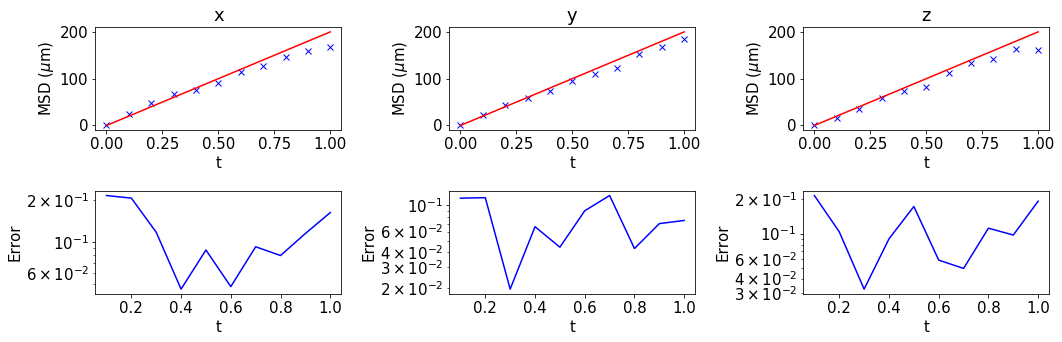

[absorbing_global:test_absorbing_diffusion]                  : passed.


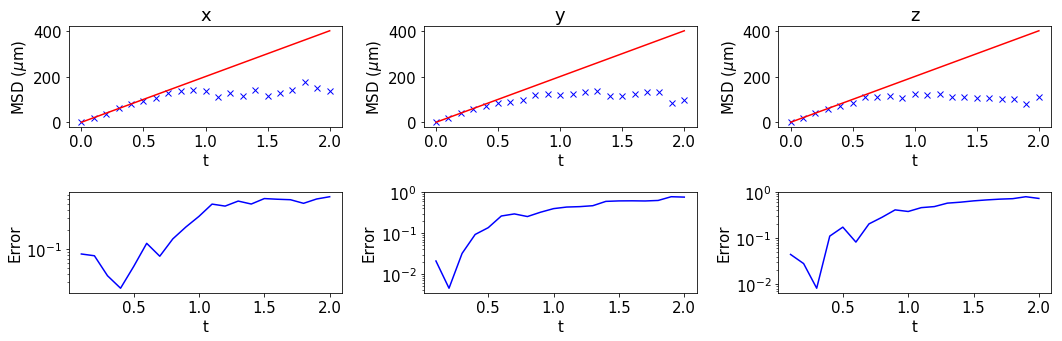

[absorbing_x:test_absorbing_diffusion]                       : passed.


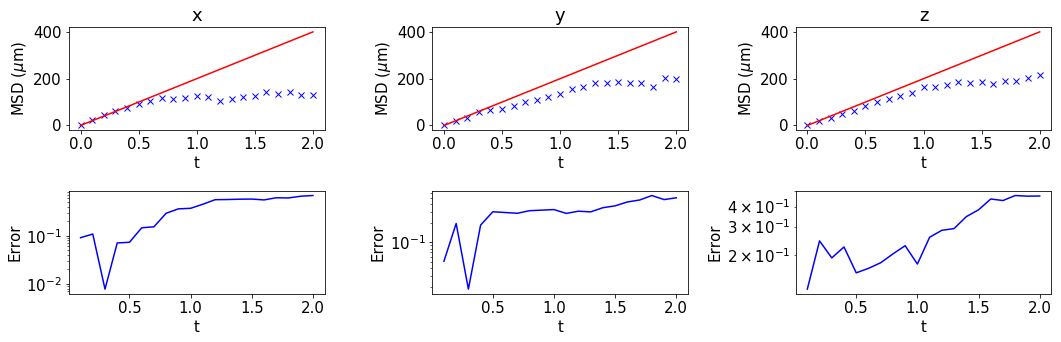

[absorbing_y:test_absorbing_diffusion]                       : passed.


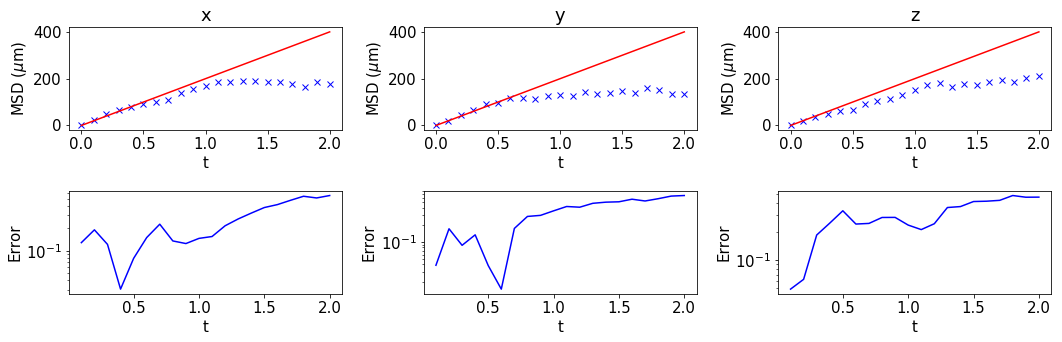

[absorbing_z:test_absorbing_diffusion]                       : passed.


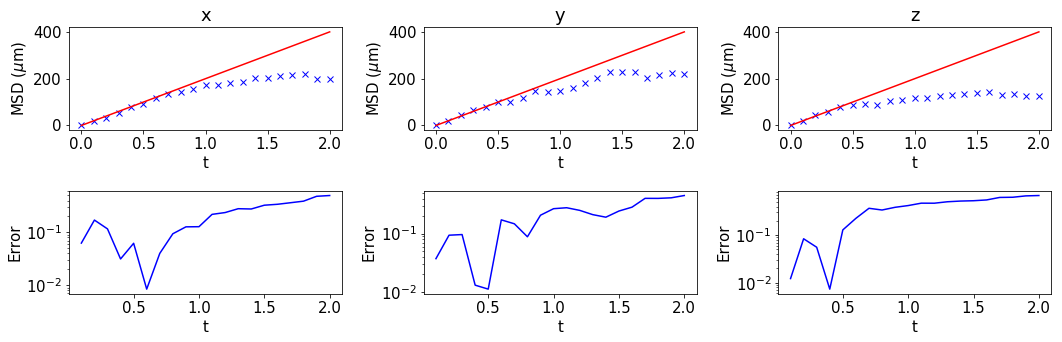

[periodic_global:test_periodic_diffusion]                    : passed.


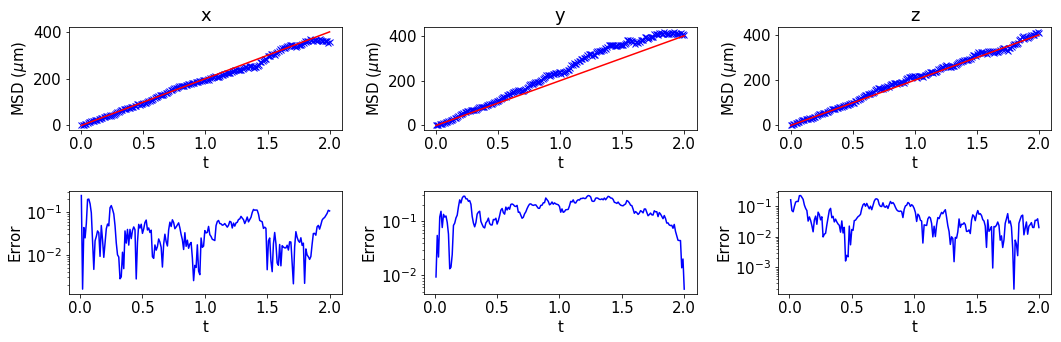

[periodic_x:test_periodic_diffusion]                         : passed.


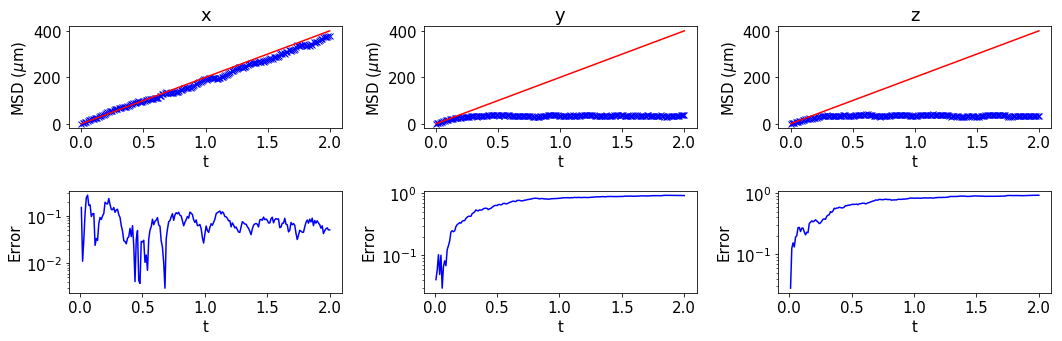

[periodic_y:test_periodic_diffusion]                         : passed.


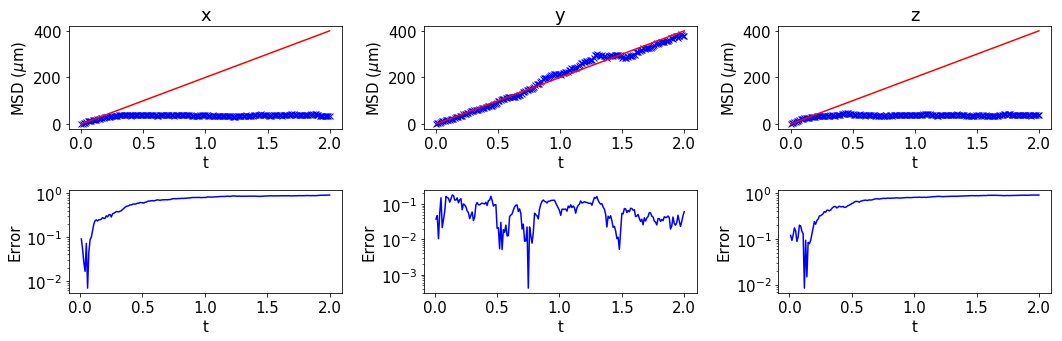

[periodic_z:test_periodic_diffusion]                         : passed.


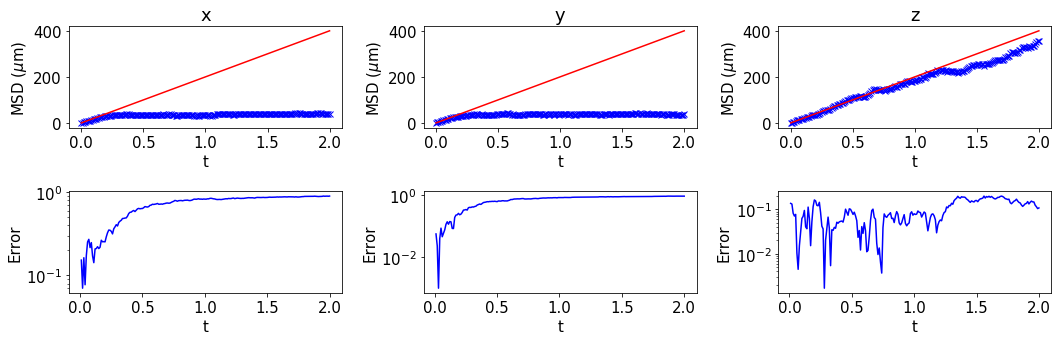

In [362]:
testMethods = {
    "reflecting_global": [test_reflecting_diffusion],
    "absorbing_global": [test_absorbing_diffusion],
    "absorbing_x": [test_absorbing_diffusion],
    "absorbing_y": [test_absorbing_diffusion],
    "absorbing_z": [test_absorbing_diffusion],
    "periodic_global": [test_periodic_diffusion],
    "periodic_x": [test_periodic_diffusion],
    "periodic_y": [test_periodic_diffusion],
    "periodic_z": [test_periodic_diffusion],
}

matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (20,5)})
i=1
for testName in testNames:
    for i,testMethod in enumerate(testMethods[testName]):
        try:
            testOutputFilename="tmp/%s.lm"%(testName)
            testMethod(testOutputFilename)
        except Exception as e:
            print "%-60s : FAILED with:"%("["+testName+":"+testMethod.__name__+"]"),e
        except:
            print "%-60s : FAILED with: Unknown exception"%("["+testName+":"+testMethod.__name__+"]")
        else:
            print "%-60s : passed."%("["+testName+":"+testMethod.__name__+"]")
        plt.tight_layout()
        plt.show()
pass

In [363]:
%%bash
rm -rf tmp